# Generative Adversarial Networks (GANs)

# Abstract

Generative Adversarial Networks are used to generate images that never existed before. They learn about the world (objects, animals and so forth) and create new versions of those images that never existed.

They have two components:

A Generator - this creates the images.
A Discriminator - this assesses the images and tells the generator if they are similar to what it has been trained on. These are based off real world examples.
When training the network, both the generator and discriminator start from scratch and learn together.

How GANs Work
G for Generative - this is a model that takes an input as a random noise singal and then outputs an image.



A for Adversarial - this is the discriminator, the opponent of the generator. This is capable of learning about objects, animals or other features specified. For example: if you supply it with pictures of dogs and non-dogs, it would be able to identify the difference between the two.



Using this example, once the discriminator has been trained, showing the discriminator a picture that isn't a dog it will return a 0. Whereas, if you show it a dog it will return a 1.



N for Network - meaning the generator and discriminator are both neural networks.

GANs Process
Step 1 - we input a random noise signal into the generator. The generator creates some images which is used for training the discriminator. We provide the discriminator with some features/images we want it to learn and the discriminator outputs probabilities. These probabilities can be rather high as the discriminator has only just started being trained. The values are then assessed and identified. The error is calculated and these are backpropagated through the discriminator, where the weights are updated.



Next we train the generator. We take the batch of images that it created and put them through the discriminator again. We do not include the feature images. The generator learns by tricking the discriminator into it outputting false positives.

The discriminator will provide an output of probabilities. The values are then assessed and compared to what they should have been. The error is calculated and backpropagated through the generator and the weights are updated.



Step 2 - This is the same as step 1 but the generator and discriminator are trained a little more. Through backpropagation the generator understands its mistakes and starts to make them more like the feature.

This is created through a Deconvolutional Neural Network.

In [0]:
from __future__ import print_function
import os
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm

In [0]:
%matplotlib inline

In [0]:
pwd

'C:\\Users\\tejas\\Desktop\\ADS\\Assignments\\Assignment 4'

In [0]:
print(os.listdir("C:\\Users\\tejas\\Desktop\\ADS\\Assignments\\Assignment 4\\butterfly-dataset\\leedsbutterfly"))

['descriptions', 'images', 'README.txt', 'segmentations']


In [0]:
batch_size = 32
batchSize = 64
imageSize = 64

# 64x64 images!
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder('C:\\Users\\tejas\\Desktop\\ADS\\Assignments\\Assignment 4\\butterfly-dataset\\leedsbutterfly', transform=transform)

dataloader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)

imgs, label = next(iter(dataloader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

In [0]:
image_size = 64

random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder('C:\\Users\\tejas\\Desktop\\ADS\\Assignments\\Assignment 4\\butterfly-dataset\\leedsbutterfly\\', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)
                                           
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


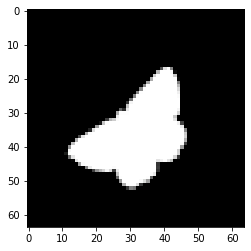

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


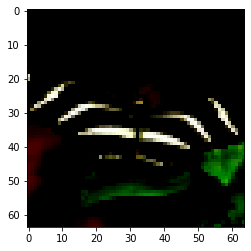

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


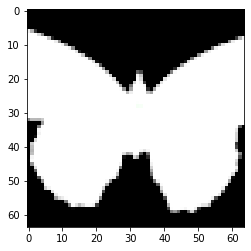

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


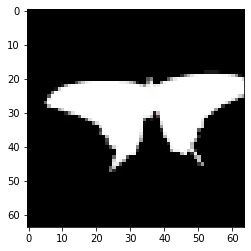

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


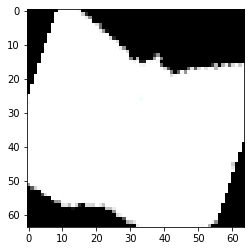

In [0]:
for i in range(5):
    plt.imshow(imgs[i])
    plt.show()

In [0]:
def weights_init(m):
    """
    Takes as input a neural network m that will initialize all its weights.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Generator

In [0]:
class G(nn.Module):
    def __init__(self):
        # Used to inherit the torch.nn Module
        super(G, self).__init__()
        # Meta Module - consists of different layers of Modules
        self.main = nn.Sequential(
                nn.ConvTranspose2d(100, 512, 4, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(True),
                nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(True),
                nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(True),
                nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False),
                nn.Tanh()
                )
        
    def forward(self, input):
        output = self.main(input)
        return output

# Creating the generator
netG = G()
netG.apply(weights_init)

G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Discriminator

In [0]:
# Defining the discriminator
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.main = nn.Sequential(
                nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
                nn.Sigmoid()
                )
        
    def forward(self, input):
        output = self.main(input)
        # .view(-1) = Flattens the output into 1D instead of 2D
        return output.view(-1)
    
    
# Creating the discriminator
netD = D()
netD.apply(weights_init)

D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

# Another setup

In [0]:
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0), # Fully connected layer via convolution.
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

    
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )

    def forward(self, imgs):
        logits = self.model(imgs)
        out = torch.sigmoid(logits)
    
        return out.view(-1, 1)

# Training

In [0]:
!mkdir results
!ls


A subdirectory or file results already exists.
'ls' is not recognized as an internal or external command,
operable program or batch file.


In [0]:
EPOCH = 10 
LR = 0.001
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(0.5, 0.999))

In [0]:
for epoch in range(EPOCH):
    for i, data in enumerate(dataloader, 0):
        # 1st Step: Updating the weights of the neural network of the discriminator
        netD.zero_grad()
        
        # Training the discriminator with a real image of the dataset
        real,_ = data
        input = Variable(real)
        target = Variable(torch.ones(input.size()[0]))
        output = netD(input)
        errD_real = criterion(output, target)
        
        # Training the discriminator with a fake image generated by the generator
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1))
        fake = netG(noise)
        target = Variable(torch.zeros(input.size()[0]))
        output = netD(fake.detach())
        errD_fake = criterion(output, target)
        
        # Backpropagating the total error
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()
        
        # 2nd Step: Updating the weights of the neural network of the generator
        netG.zero_grad()
        target = Variable(torch.ones(input.size()[0]))
        output = netD(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step()
        
        # 3rd Step: Printing the losses and saving the real images and the generated images of the minibatch every 100 steps
        print('[%d/%d][%d/%d] Loss_D: %.4f; Loss_G: %.4f' % (epoch, EPOCH, i, len(dataloader), errD.item(), errG.item()))
        if i % 100 == 0:
            vutils.save_image(real, '%s/real_samples.png' % "./results", normalize=True)
            fake = netG(noise)
            vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./results", epoch), normalize=True)

[0/10][0/52] Loss_D: 1.6345; Loss_G: 29.1547
[0/10][1/52] Loss_D: 1.7399; Loss_G: 25.3931
[0/10][2/52] Loss_D: 5.2934; Loss_G: 36.4857
[0/10][3/52] Loss_D: 2.9229; Loss_G: 37.6525
[0/10][4/52] Loss_D: 0.2378; Loss_G: 36.0576
[0/10][5/52] Loss_D: 0.0006; Loss_G: 29.0998
[0/10][6/52] Loss_D: 13.9994; Loss_G: 33.2017
[0/10][7/52] Loss_D: 0.1397; Loss_G: 27.1281
[0/10][8/52] Loss_D: 7.2316; Loss_G: 17.5670
[0/10][9/52] Loss_D: 8.2799; Loss_G: 25.6905
[0/10][10/52] Loss_D: 5.1781; Loss_G: 6.4606
[0/10][11/52] Loss_D: 7.3300; Loss_G: 10.0651
[0/10][12/52] Loss_D: 1.0022; Loss_G: 9.4267
[0/10][13/52] Loss_D: 2.5645; Loss_G: 9.5805
[0/10][14/52] Loss_D: 0.8304; Loss_G: 7.2414
[0/10][15/52] Loss_D: 1.3157; Loss_G: 14.6097
[0/10][16/52] Loss_D: 1.5143; Loss_G: 7.0565
[0/10][17/52] Loss_D: 0.9596; Loss_G: 4.8887
[0/10][18/52] Loss_D: 1.2663; Loss_G: 7.9806
[0/10][19/52] Loss_D: 0.2637; Loss_G: 9.2206
[0/10][20/52] Loss_D: 0.2483; Loss_G: 7.5406
[0/10][21/52] Loss_D: 0.5970; Loss_G: 7.3444
[0/10][

[7/10][0/52] Loss_D: 1.2955; Loss_G: 1.3528
[7/10][1/52] Loss_D: 0.7614; Loss_G: 2.4059
[7/10][2/52] Loss_D: 1.3198; Loss_G: 1.0274
[7/10][3/52] Loss_D: 1.2075; Loss_G: 2.5315
[7/10][4/52] Loss_D: 1.7747; Loss_G: 0.2632
[7/10][5/52] Loss_D: 2.0131; Loss_G: 2.4686
[7/10][6/52] Loss_D: 0.6728; Loss_G: 2.6763
[7/10][7/52] Loss_D: 0.9764; Loss_G: 0.9114
[7/10][8/52] Loss_D: 1.0916; Loss_G: 1.6370
[7/10][9/52] Loss_D: 1.0428; Loss_G: 2.2581
[7/10][10/52] Loss_D: 1.5552; Loss_G: 0.9618
[7/10][11/52] Loss_D: 1.6366; Loss_G: 1.3476
[7/10][12/52] Loss_D: 0.9342; Loss_G: 2.4095
[7/10][13/52] Loss_D: 1.7267; Loss_G: 0.6404
[7/10][14/52] Loss_D: 1.5296; Loss_G: 3.1015
[7/10][15/52] Loss_D: 1.9609; Loss_G: 1.2768
[7/10][16/52] Loss_D: 1.4280; Loss_G: 1.4479
[7/10][17/52] Loss_D: 1.2729; Loss_G: 1.9295
[7/10][18/52] Loss_D: 1.1567; Loss_G: 1.7695
[7/10][19/52] Loss_D: 1.1570; Loss_G: 1.2000
[7/10][20/52] Loss_D: 1.3091; Loss_G: 1.8403
[7/10][21/52] Loss_D: 1.5495; Loss_G: 1.0502
[7/10][22/52] Loss_D

In [0]:
batch_size = 32
LR_G = 0.001
LR_D = 0.0005

beta1 = 0.5
epochs = 20

real_label = 0.9
fake_label = 0
nz = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=LR_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR_G, betas=(beta1, 0.999))

fixed_noise = torch.randn(25, nz, 1, 1, device=device)

G_losses = []
D_losses = []
epoch_time = []


In [0]:
def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH "+ str(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [0]:
def show_generated_img(n_images=5):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)
    
    figure, axes = plt.subplots(1, len(sample), figsize = (64,64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample[index]
        axis.imshow(image_array)
        
    plt.show()
    plt.close()

[1/20][26/52] Loss_D: 2.0376 Loss_G: 10.1904 D(x): 0.9001 D(G(z)): 0.8012 / 0.0000
[1/20][52/52] Loss_D: 1.0708 Loss_G: 2.1447 D(x): 0.6982 D(G(z)): 0.3987 / 0.1026



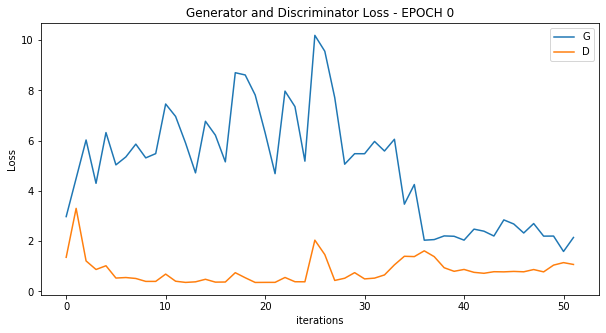

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


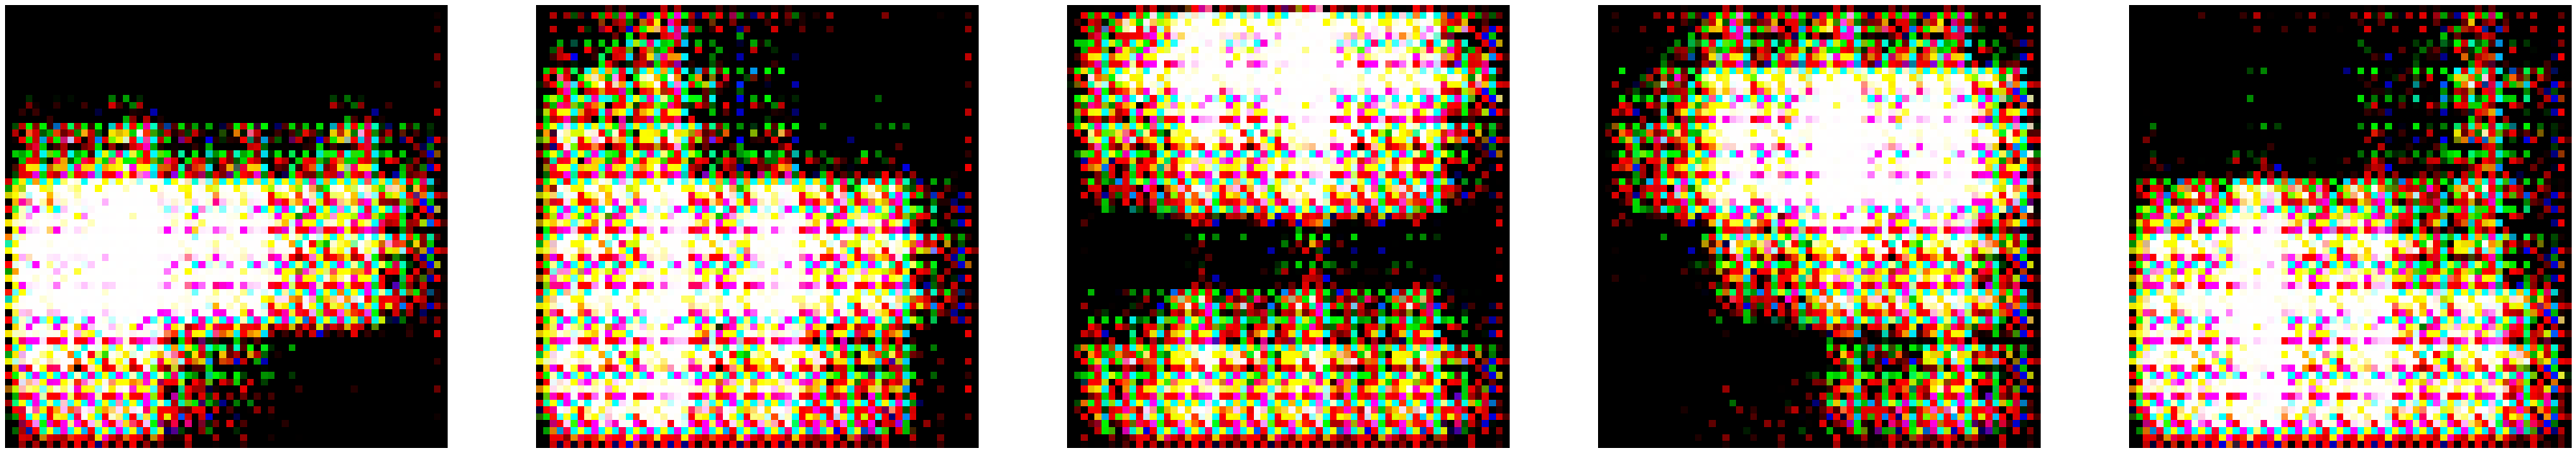

[2/20][26/52] Loss_D: 0.9267 Loss_G: 1.6752 D(x): 0.5433 D(G(z)): 0.2065 / 0.1796
[2/20][52/52] Loss_D: 1.3036 Loss_G: 1.0350 D(x): 0.4452 D(G(z)): 0.3327 / 0.3609



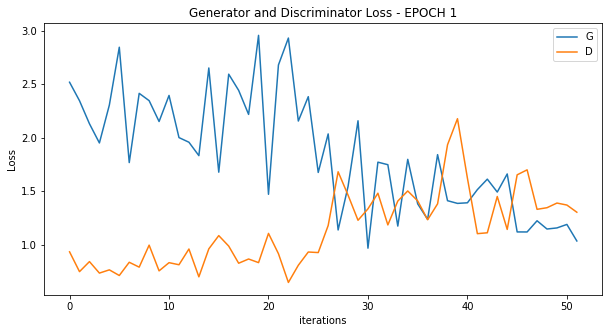

[3/20][26/52] Loss_D: 1.3733 Loss_G: 0.9647 D(x): 0.4343 D(G(z)): 0.3820 / 0.3747
[3/20][52/52] Loss_D: 1.2691 Loss_G: 0.9090 D(x): 0.5311 D(G(z)): 0.4373 / 0.4024



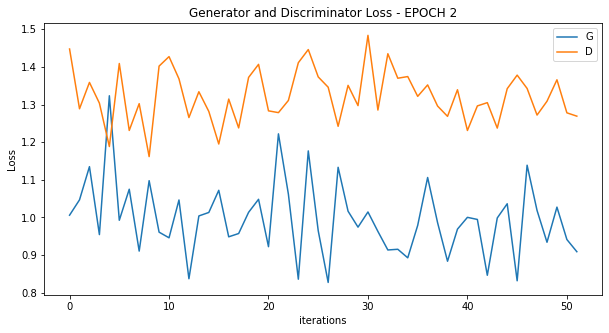

[4/20][26/52] Loss_D: 1.3004 Loss_G: 0.9099 D(x): 0.4340 D(G(z)): 0.3533 / 0.4061
[4/20][52/52] Loss_D: 1.4072 Loss_G: 0.8991 D(x): 0.4221 D(G(z)): 0.4164 / 0.3961



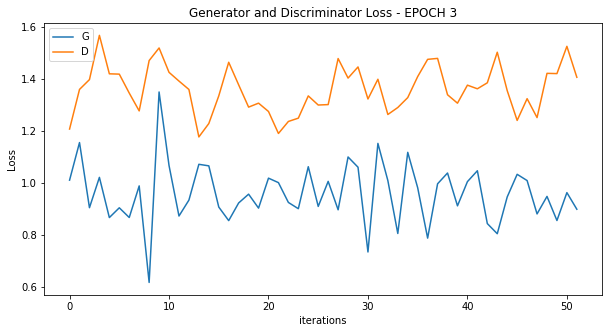

[5/20][26/52] Loss_D: 1.3636 Loss_G: 0.8889 D(x): 0.4035 D(G(z)): 0.3683 / 0.4115
[5/20][52/52] Loss_D: 1.2791 Loss_G: 0.9627 D(x): 0.5423 D(G(z)): 0.4583 / 0.3738



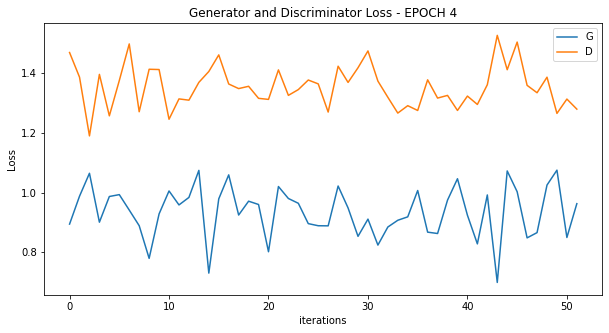

[6/20][26/52] Loss_D: 1.3891 Loss_G: 0.8777 D(x): 0.4334 D(G(z)): 0.4121 / 0.4067
[6/20][52/52] Loss_D: 1.3904 Loss_G: 0.8688 D(x): 0.4095 D(G(z)): 0.3934 / 0.4112



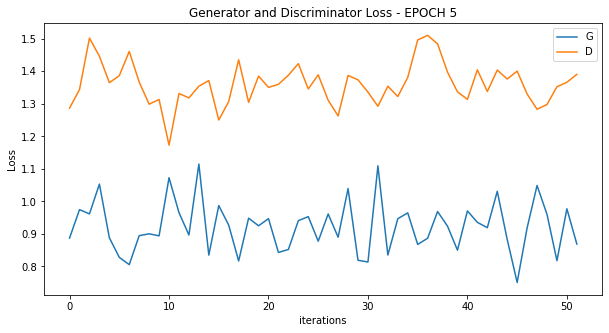

[7/20][26/52] Loss_D: 1.4436 Loss_G: 0.8843 D(x): 0.4720 D(G(z)): 0.4792 / 0.4037
[7/20][52/52] Loss_D: 1.4659 Loss_G: 0.9151 D(x): 0.4555 D(G(z)): 0.4817 / 0.3973



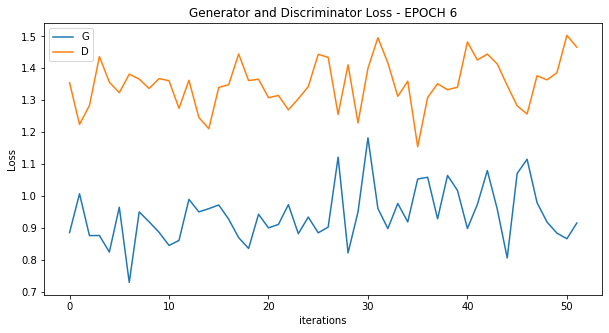

[8/20][26/52] Loss_D: 1.5554 Loss_G: 0.9355 D(x): 0.3516 D(G(z)): 0.4061 / 0.3782
[8/20][52/52] Loss_D: 1.3818 Loss_G: 0.9382 D(x): 0.3890 D(G(z)): 0.3677 / 0.3823



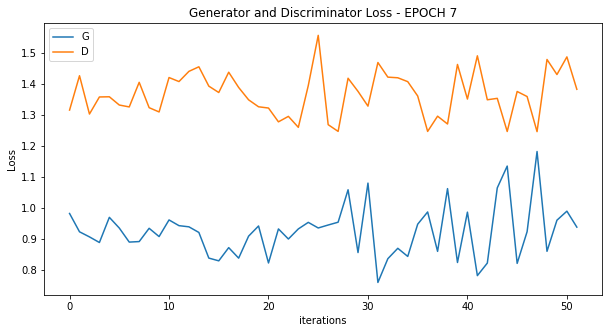

[9/20][26/52] Loss_D: 1.4148 Loss_G: 0.8044 D(x): 0.4792 D(G(z)): 0.4761 / 0.4434
[9/20][52/52] Loss_D: 1.3685 Loss_G: 0.9212 D(x): 0.4790 D(G(z)): 0.4601 / 0.3903



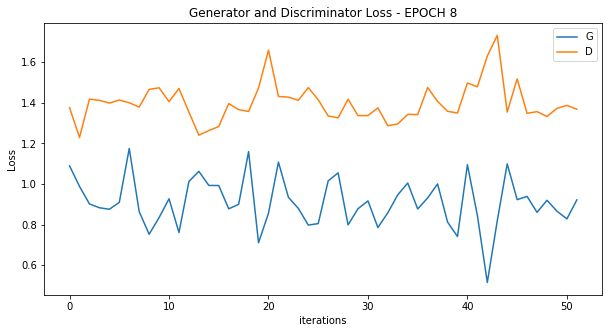

[10/20][26/52] Loss_D: 1.3744 Loss_G: 0.9032 D(x): 0.4816 D(G(z)): 0.4633 / 0.3958
[10/20][52/52] Loss_D: 1.3360 Loss_G: 0.8683 D(x): 0.4605 D(G(z)): 0.4285 / 0.4096



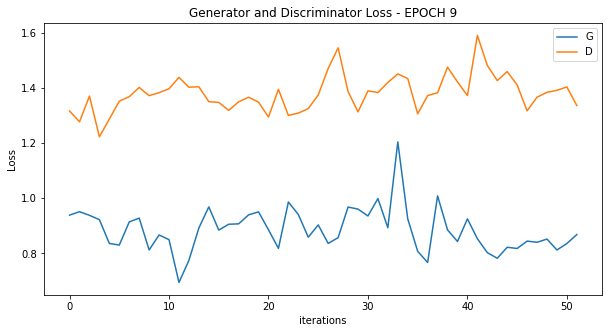

[11/20][26/52] Loss_D: 1.4324 Loss_G: 0.8687 D(x): 0.4014 D(G(z)): 0.4144 / 0.4110
[11/20][52/52] Loss_D: 1.4021 Loss_G: 0.9223 D(x): 0.5247 D(G(z)): 0.5147 / 0.3836



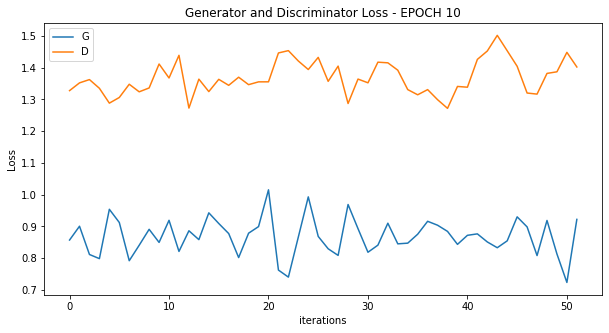

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


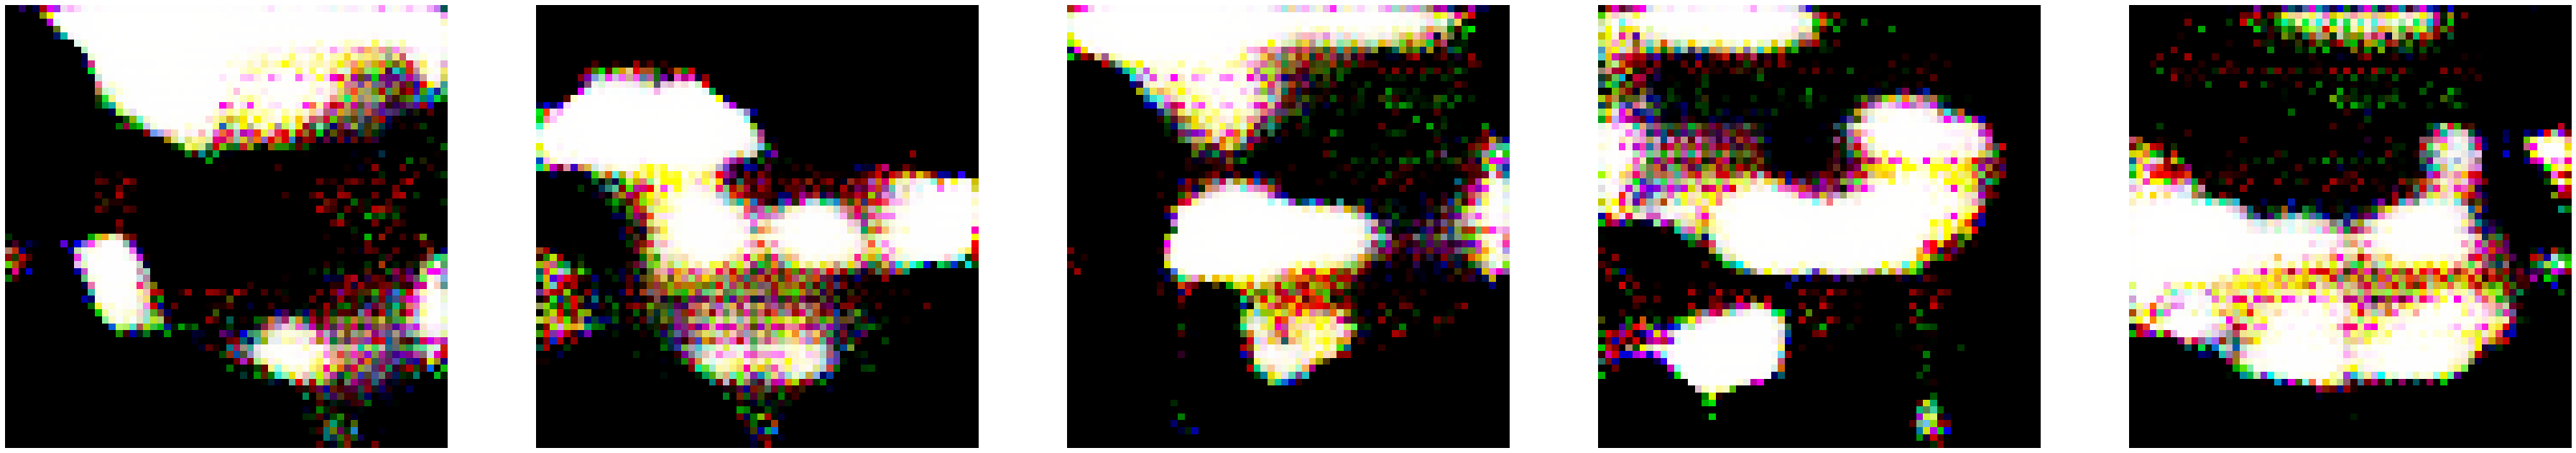

[12/20][26/52] Loss_D: 1.3993 Loss_G: 0.8747 D(x): 0.4369 D(G(z)): 0.4263 / 0.4085
[12/20][52/52] Loss_D: 1.4316 Loss_G: 0.9092 D(x): 0.4220 D(G(z)): 0.4344 / 0.3942



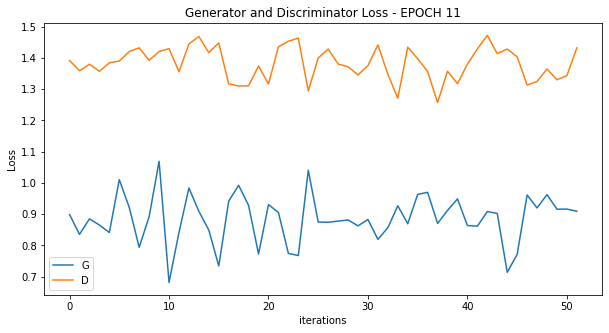

[13/20][26/52] Loss_D: 1.2664 Loss_G: 0.8948 D(x): 0.4708 D(G(z)): 0.3982 / 0.3970
[13/20][52/52] Loss_D: 1.4402 Loss_G: 0.8142 D(x): 0.5160 D(G(z)): 0.5255 / 0.4403



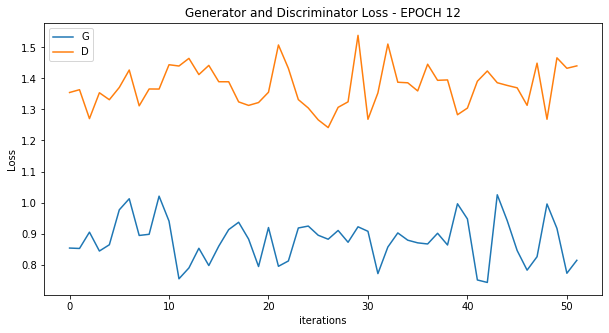

[14/20][26/52] Loss_D: 1.3298 Loss_G: 0.8572 D(x): 0.4194 D(G(z)): 0.3806 / 0.4123
[14/20][52/52] Loss_D: 1.4444 Loss_G: 0.7644 D(x): 0.4023 D(G(z)): 0.4248 / 0.4692



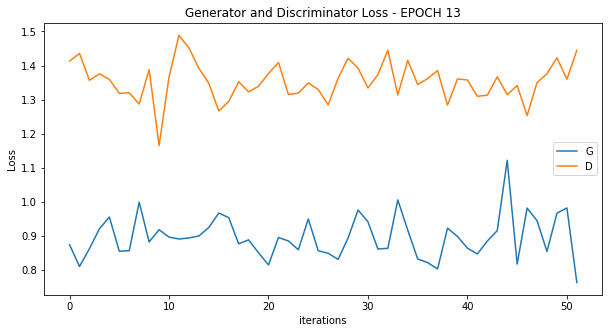

[15/20][26/52] Loss_D: 1.3155 Loss_G: 1.0000 D(x): 0.4450 D(G(z)): 0.3924 / 0.3647
[15/20][52/52] Loss_D: 1.3401 Loss_G: 0.8315 D(x): 0.4490 D(G(z)): 0.4147 / 0.4270



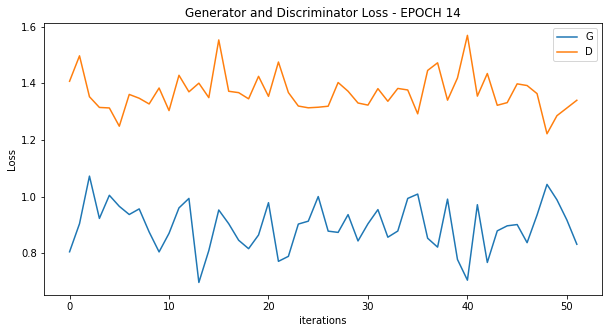

[16/20][26/52] Loss_D: 1.2355 Loss_G: 0.9247 D(x): 0.4929 D(G(z)): 0.3990 / 0.3875
[16/20][52/52] Loss_D: 1.3742 Loss_G: 0.8784 D(x): 0.4286 D(G(z)): 0.3993 / 0.4101



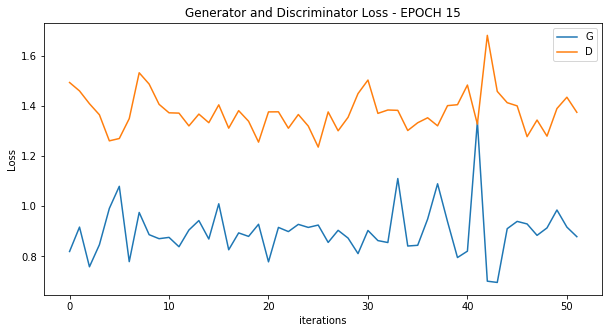

[17/20][26/52] Loss_D: 1.4171 Loss_G: 0.9119 D(x): 0.4407 D(G(z)): 0.4468 / 0.4014
[17/20][52/52] Loss_D: 1.3569 Loss_G: 0.8493 D(x): 0.4824 D(G(z)): 0.4554 / 0.4205



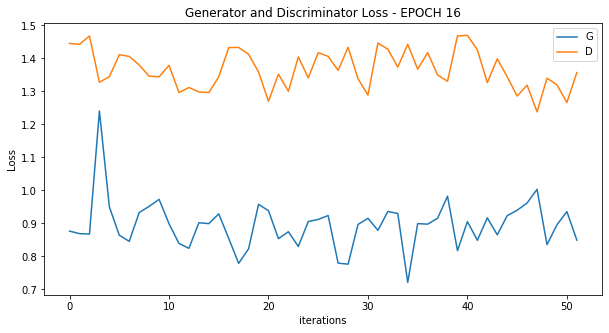

[18/20][26/52] Loss_D: 1.3104 Loss_G: 0.8469 D(x): 0.4408 D(G(z)): 0.3918 / 0.4233
[18/20][52/52] Loss_D: 1.3174 Loss_G: 0.9382 D(x): 0.4677 D(G(z)): 0.4193 / 0.3826



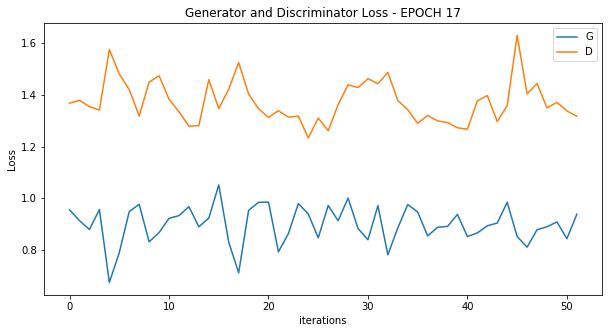

[19/20][26/52] Loss_D: 1.3818 Loss_G: 0.8448 D(x): 0.4862 D(G(z)): 0.4737 / 0.4213
[19/20][52/52] Loss_D: 1.4476 Loss_G: 0.8371 D(x): 0.4750 D(G(z)): 0.4851 / 0.4273



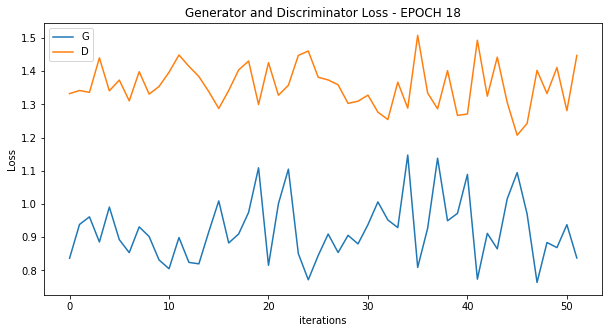

[20/20][26/52] Loss_D: 1.3883 Loss_G: 0.9154 D(x): 0.3602 D(G(z)): 0.3162 / 0.3989
[20/20][52/52] Loss_D: 1.3233 Loss_G: 0.9506 D(x): 0.4335 D(G(z)): 0.3813 / 0.3818



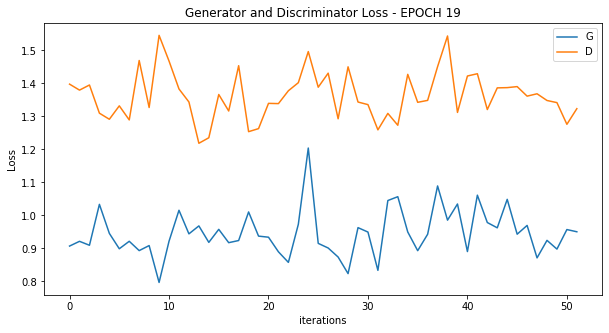

In [0]:
for epoch in range(epochs):
    
    start = time.time()
    for ii, (real_images, train_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)

        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
    plot_loss (G_losses, D_losses, epoch)
    G_losses = []
    D_losses = []
    if epoch % 10 == 0:
        show_generated_img()

    epoch_time.append(time.time()- start)
    
#             valid_image = netG(fixed_noise)


In [0]:
print (">> average EPOCH duration = ", np.mean(epoch_time))


>> average EPOCH duration =  189.19325746297835


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


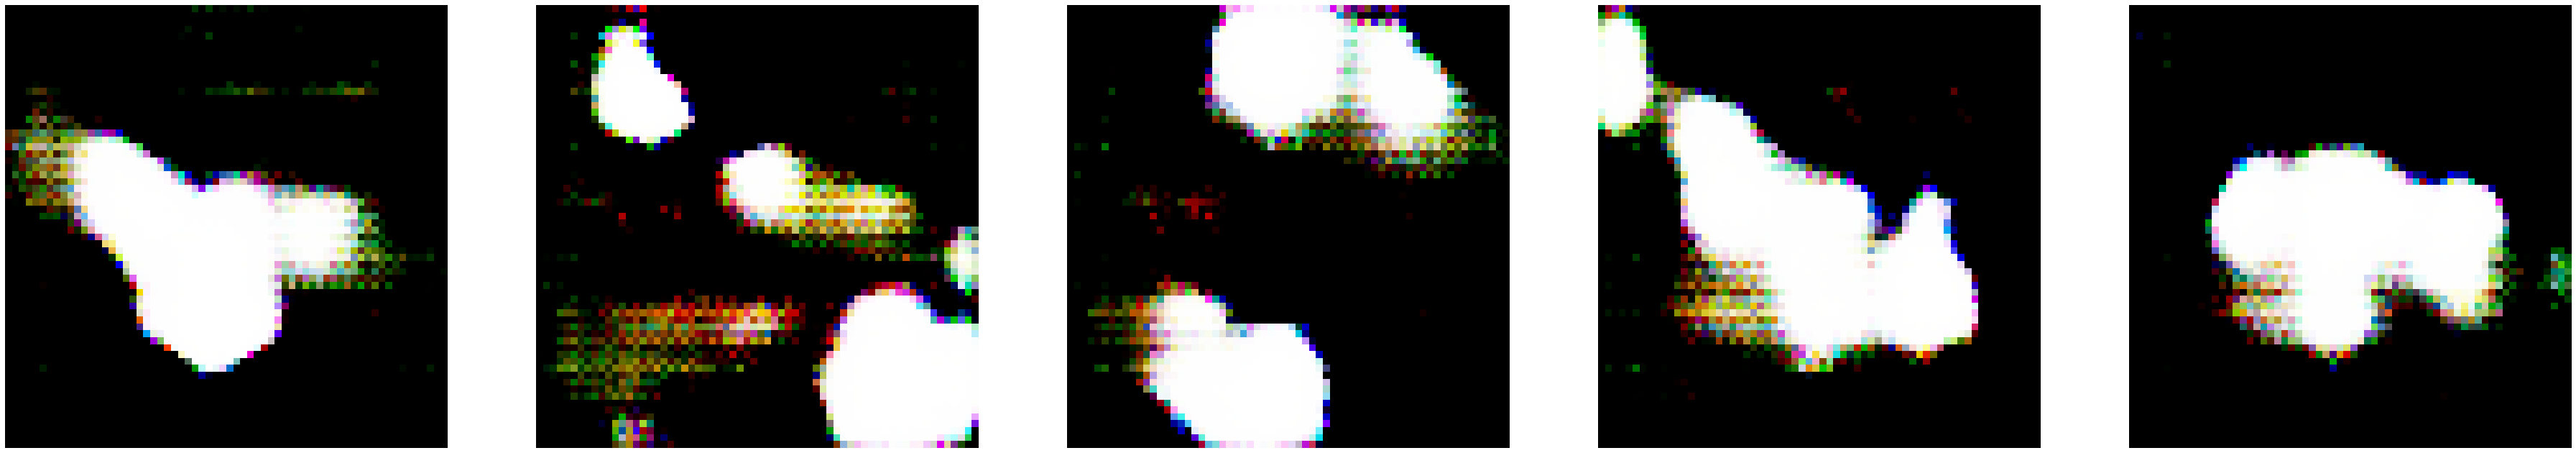

In [0]:
show_generated_img(5)

In [0]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
    
im_batch_size = 50
n_images=10000

for i_batch in tqdm(range(0, n_images, im_batch_size)):
    gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))

# Conclusion

We built a introductory GAN model to generate a new butterfly images. Tried different number of epochs to train the model. Plotted  graph t see the reduction in a loss function of generatoe 

# Citations


https://www.kaggle.com/veeralakrishna/butterfly-dataset
https://www.kaggle.com/jesucristo/gan-introduction

# License

Copyright 2020 Tejaswini Talekar

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE